In [2]:
from transformers import GPT2LMHeadModel

In [4]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") #124M model
sd_hf = model_hf.state_dict() # raw tensors 


for k, v in sd_hf.items():
    print(k, v.shape)

# 50257 is the vocab_size 
# 768 si the emb_dim
# 1024 is the context_size 
# transformer.wpe.weight torch.Size([1024, 768]) is the position embedding
# transformer.wte.weight torch.Size([50257, 768]) is the token embedding

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In theory, the token embedding dimension and positional embedding dimension don't necessarily need to be equal, but in practice, they usually are equal in most modern transformer architectures. 

In [8]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

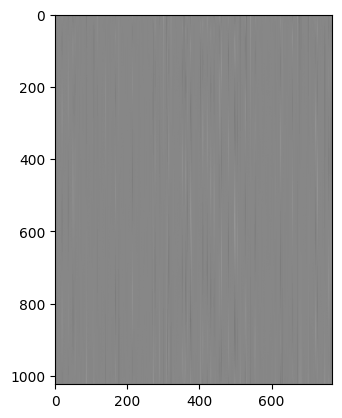

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

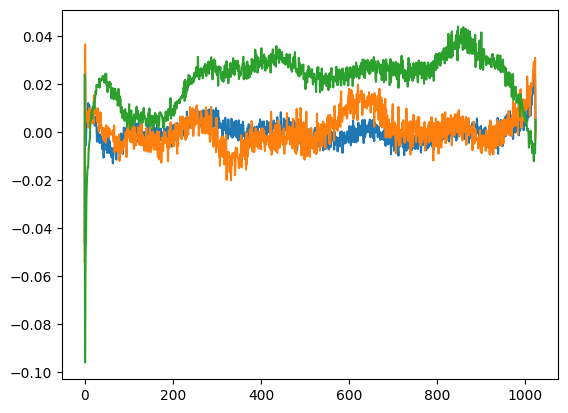

In [12]:
# we just grab three random columns from 768 available columns
# we want to analyze what each channel is doing as a function of position.
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

# In the original transformers papaer, the positional embedding are fixed sinosoidal functions
# For GPT-2, positional embeddings are trainable parameters.

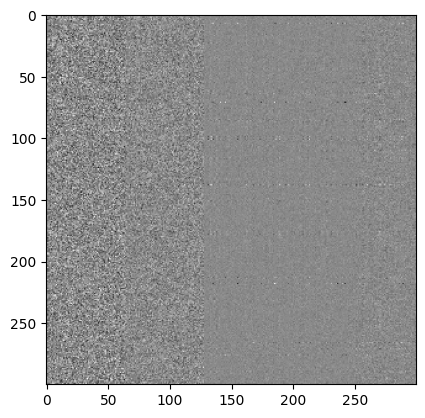

In [14]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

In [17]:
from transformers import pipeline, set_seed

generator = pipeline("text-generation", model="gpt2")
set_seed(42)

generator("Hello, I'm a language model, ", max_length=30, num_return_sequences=5)

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, \xa0it's not easy to write a game that makes sense in one programming language, but I tried it"},
 {'generated_text': 'Hello, I\'m a language model, "\n\n"Nonsense!"\n\n"A language model is a concept that is used to model'},
 {'generated_text': "Hello, I'm a language model, \xa0and I write a language class that converts data from English text into a French one to French-speaking"},
 {'generated_text': "Hello, I'm a language model, _____. Your work on this app is an extension of me. Please take care about your data, please"},
 {'generated_text': "Hello, I'm a language model, \xa0and these models are really hard, \xa0so I'm going to show you some example of how"}]

In [ ]:
# the results we get from generation of our version of GPT is not comparable to the huggingface generation pipeline:
# These are the generated text by out implementation of GPT

# > Hello, I'm a language model. I'm talking about the abstractions of languages. Those things are easy to understand: you can program them yourself
# > Hello, I'm a language model. So you are supposed to understand that you do not talk about a single language with it. People understand languages too
# > Hello, I'm a language model. What's this? A model for the world of "completing" a task? And in an even more
# > Hello, I'm a language model. I wrote this post as a way to learn this stuff and show others how to use the Language Model.
# > Hello, I'm a language model. A language model is an abstraction of what we're talking about, and it's about getting real. It's

# So, we are gonna sample manually from the huggingface GPT
import torch 
from torch.nn import functional as F

from transformers import GPT2LMHeadModel

max_length = 30
num_return_sequences = 5

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
# model.to("cuda") # I don't have GPU for now!


import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("Hello, I'm a language model.")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens

while x.size(1) <= max_length:
    with torch.no_grad():
        logits = model(x)[0]
        # we are interested in the logits in the last position
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)

# genrate text
for i in range(num_return_sequences):
    decoded = enc.decode(x[i, :max_length].tolist())
    print(decoded)

Hello, I'm a language model. I'm talking about the abstractions of languages. Those things are easy to understand: you can program them yourself
Hello, I'm a language model. So you are supposed to understand that you do not talk about a single language with it. People understand languages too
Hello, I'm a language model. What's this? A model for the world of "completing" a task? And in an even more
Hello, I'm a language model. I wrote this post as a way to learn this stuff and show others how to use the Language Model.

Hello, I'm a language model. A language model is an abstraction of what we're talking about, and it's about getting real. It's
